In [1]:
import difflib
import json
import os
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from language_classifier.language_classifier import LanguageClassifier
clf_0_2 = LanguageClassifier(max_incorrect_words=0, min_words_in_language=2)
clf_1_2 = LanguageClassifier(max_incorrect_words=1, min_words_in_language=2)
clf_1_3 = LanguageClassifier(max_incorrect_words=1, min_words_in_language=3)
clf_1_4 = LanguageClassifier(max_incorrect_words=1, min_words_in_language=4)

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)

# import data

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# helper functions

In [3]:
def preview_publication(pub_number):
    if type(pub_number) is pd.DataFrame and pub_number.shape[0] == 1:
        try:
            pub_number = pub_number['pub_number'].values[0]
        except ValueError:
            return None
    elif type(pub_number) is pd.Series:
        try:
            pub_number = pub_number.values[0]
        except ValueError:
            return None
    
    try:
        output_df = weblinks_df[weblinks_df.pub_number == pub_number].T
    except Exception as e:
        print(e)
        return None
        
    return output_df


In [6]:
# DATA CLEANING FUNCTIONS

def get_files_for_publication(pub_number, fr_eng_correlation_df):
    row = fr_eng_correlation_df.loc[fr_eng_correlation_df['pub_number'] == pub_number]
    if not row.empty:
        filename_fr = row['filename_fr'].values[0]
        filename_en = row['filename_en'].values[0]
        return filename_fr, filename_en
    return None, None


def get_json_file_link(parsed_docs_folder, pdf_filename):
    if pdf_filename.endswith(".pdf"):
        json_filename = pdf_filename + ".json"
        for root, _, files in os.walk(parsed_docs_folder):
            if json_filename in files:
                return os.path.join(root, json_filename)
    return None


def extract_text_from_single_file(json_file, target_language, clf):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = data['text']
    text_blocks = re.split(r'[.\n?]', full_text)
    text = []

    for block in text_blocks:
        block = block.strip()
        if not block:
            continue
            
        if clf.classify(block) == target_language:
            text.append(block)        

    return " ".join(text)


def extract_both_languages_from_two_files(json_file_fr, json_file_en, clf):
    return extract_text_from_single_file(json_file_fr, "fr", clf), extract_text_from_single_file(json_file_en, "en", clf)


def extract_both_languages_from_single_file(json_file, clf):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = data['text']
    text_blocks = re.split(r'[.\n?]', full_text)
    text_fr, text_en = [], []

    for block in text_blocks:
        block = block.strip()
        if not block:
            continue
            
        if clf.classify(block) == "fr":
            text_fr.append(block)   
        elif clf.classify(block) == "en":
            text_en.append(block)   

    return " ".join(text_fr), " ".join(text_en)


def correlate_and_clean_text(text_fr, text_en):
    matcher = difflib.SequenceMatcher(None, text_fr.split(), text_en.split())
    matched_fr, matched_en = [], []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            matched_fr.append(" ".join(text_fr.split()[i1:i2]))
            matched_en.append(" ".join(text_en.split()[j1:j2]))
    
    return matched_fr, matched_en


def process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf):
    debug = True  # TODO: remove after DEBUG
    
    matched_data = []
    min_text_quality = 1
    
    for _, row in fr_eng_correlation_df.iterrows():
        pub_number = row['pub_number']
        filename_fr, filename_en = row['filename_fr'], row['filename_en']
        
        if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
            continue
        
        fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
        if fr_link == None:
            continue
        
        if filename_fr == filename_en:
            text_fr, text_en = extract_both_languages_from_single_file(fr_link, clf)
        else:
            en_link = get_json_file_link(parsed_docs_folder, filename_en) 
            if en_link == None:
                continue
            text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, clf            )
        
        if debug:
            matched_fr, matched_en = text_fr, text_en  # TODO: remove after DEBUG
        else:            
            matched_fr, matched_en = correlate_and_clean_text(text_fr, text_en)  # TODO: confirm
        
        matched_data.append({'pub_number': pub_number, 'text_fr': matched_fr, 'text_en': matched_en})
    
    return pd.DataFrame(matched_data)


In [69]:
matched_df_0_2 = process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf_0_2)
matched_df_1_2 = process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf_1_2)
matched_df_1_3 = process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf_1_3)
matched_df_1_4 = process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf_1_4)

for df in [matched_df_0_2, matched_df_1_2, matched_df_1_3, matched_df_1_4]:
    df['len_fr'] = df['text_fr'].str.len()
    df['len_en'] = df['text_en'].str.len()
    df['len_diff'] = np.where(
        df[['len_fr', 'len_en']].min(axis=1) == 0,
        9999,
        df[['len_fr', 'len_en']].max(axis=1) / df[['len_fr', 'len_en']].min(axis=1)
    )

In [70]:
pd.concat([
    matched_df_0_2.rename({'len_diff': 't=0, n=2'}, axis=1)['t=0, n=2'].describe(percentiles=[0.975, .75, 0.5, .25, .025]),
    matched_df_1_2.rename({'len_diff': 't=1, n=2'}, axis=1)['t=1, n=2'].describe(percentiles=[0.975, .75, 0.5, .25, .025]),
    matched_df_1_3.rename({'len_diff': 't=1, n=3'}, axis=1)['t=1, n=3'].describe(percentiles=[0.975, .75, 0.5, .25, .025]),
    matched_df_1_4.rename({'len_diff': 't=1, n=4'}, axis=1)['t=1, n=4'].describe(percentiles=[0.975, .75, 0.5, .25, .025]),
], axis=1).drop(['std', 'count', 'mean'])

,"t=0, n=2","t=1, n=2","t=1, n=3","t=1, n=4"
min,1.0,1.0,1.0,1.0
2.5%,1.1,1.1,1.2,1.2
25%,1.3,1.3,1.3,1.4
50%,7.9,7.6,7.6,8.1
75%,18.0,17.4,17.2,19.2
97.5%,9999.0,1039.8,9999.0,9999.0
max,9999.0,9999.0,9999.0,9999.0


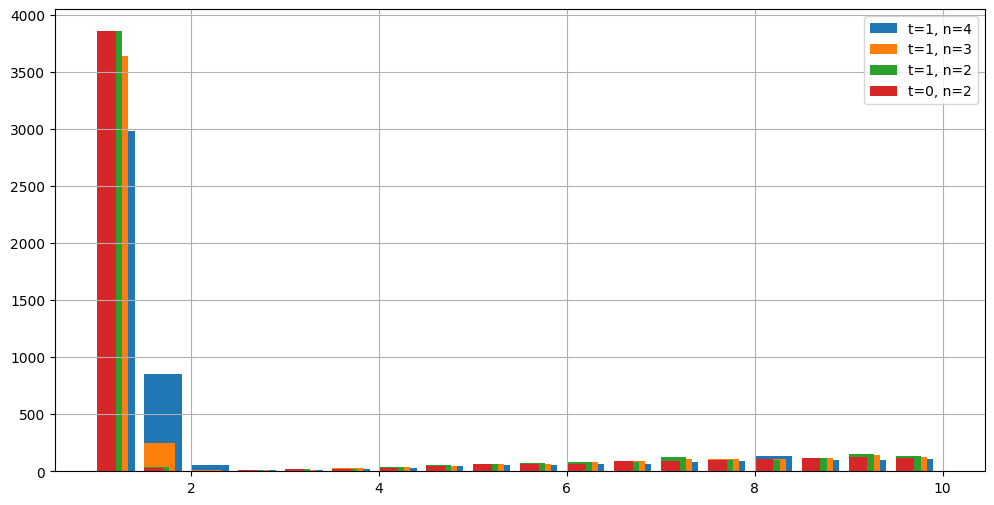

In [73]:
plt.figure(figsize=(12, 6))

bins = [x/2 for x in range(2, 21)]
data = [
    (matched_df_1_4, 't=1, n=4'),
    (matched_df_1_3, 't=1, n=3'), 
    (matched_df_1_2, 't=1, n=2'), 
    (matched_df_0_2, 't=0, n=2'), 
]

for i, (df, label) in enumerate(data):
    df['len_diff'].hist(bins=bins, width=(0.4-i/15), label=label)
    
plt.legend()
plt.show()

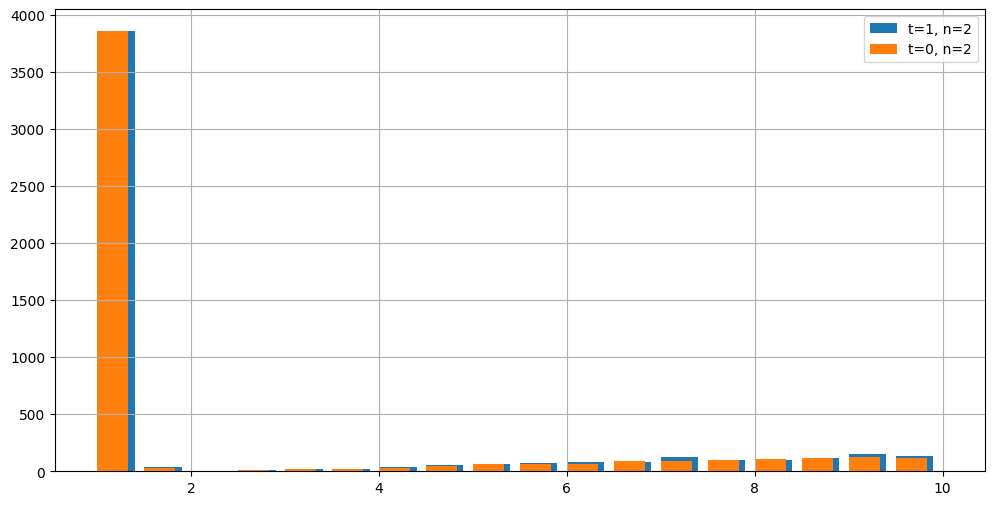

In [74]:
plt.figure(figsize=(12, 6))

bins = [x/2 for x in range(2, 21)]
data = [
    (matched_df_1_2, 't=1, n=2'), 
    (matched_df_0_2, 't=0, n=2'), 
]

for i, (df, label) in enumerate(data):
    df['len_diff'].hist(bins=bins, width=(0.4-i/15), label=label)
    
plt.legend()
plt.show()

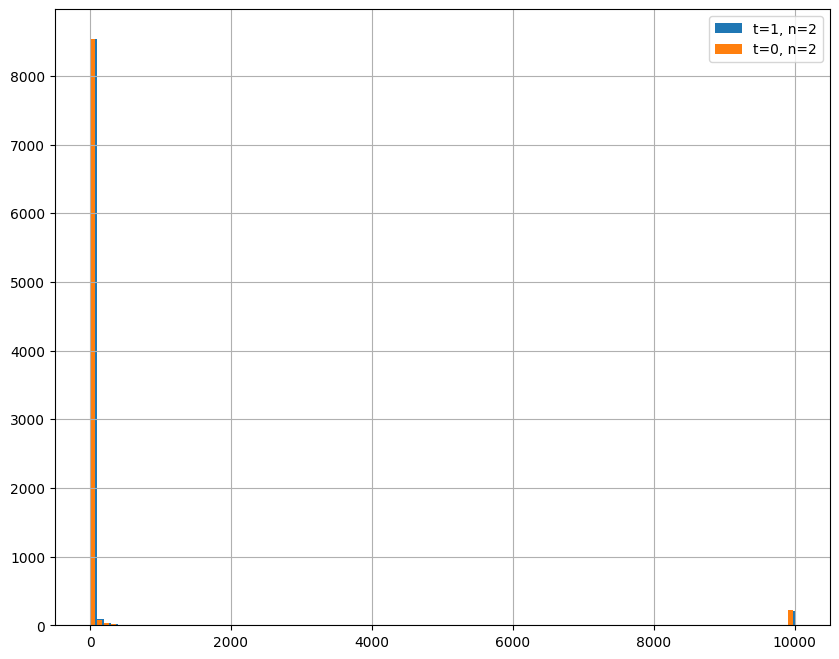

In [94]:
plt.show()
plt.figure(figsize=(10, 8))

data = [
    (matched_df_1_2, 't=1, n=2'),
    (matched_df_0_2, 't=0, n=2'),
]
n = 100

for i, (df, label) in enumerate(data):
    df['len_diff'].hist(bins=n, width=(10000/n-i*3000/n), label=label)

plt.legend()
plt.show()

# looks liek tolerance 1 is VERY VERY SLIGHTLY better